In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score,mean_squared_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
pd.set_option('display.max_columns', 25)

In [4]:
# Define a semente
seed_value = 2023
tf.random.set_seed(seed_value)
np.random.seed(seed_value)

2. **(Com Nota)** Mushroom: problema binário. A base mushrooms.csv contém dados de **duas** espécies de cogumelos. A base está completamente criptografada e não há um dicionário.

**Projeto**:
* Testem diferentes arquiteturas para responder a esses problemas;
* Testem diferentes otimizadores;
* Dependendo da função de perda, adaptem o learning rate.

**Entrega:**
Realizem a predição da base mushrooms_AC.csv e salvem no drive da respectiva AC. Usem como nome do arquivo NOME_SOBRENOME_NOME2_SOBRENOME2.csv . Utilizem o formato padrão do pandas para exportar o arquivo.

A métrica para avaliar será a **acurácia**.

In [5]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data Science/Databases/AC3/mushrooms.csv')
df.tail()

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat,class
7495,x,y,e,t,n,f,c,b,w,t,b,s,s,g,p,p,w,o,p,n,v,d,e
7496,f,s,n,f,f,f,c,n,b,t,?,s,s,w,p,p,w,o,e,w,v,l,p
7497,x,f,g,f,n,f,w,b,n,t,e,s,s,w,w,p,w,o,e,n,s,g,e
7498,x,s,n,t,p,f,c,n,p,e,e,s,s,w,w,p,w,o,p,n,v,g,p
7499,x,s,n,t,p,f,c,n,w,e,e,s,s,w,w,p,w,o,p,k,s,u,p


In [6]:
dict(df['class'].value_counts()) # base ta balanciada

{'e': 3885, 'p': 3615}

In [7]:
df = pd.get_dummies(df, dtype=float, drop_first=False)

In [16]:
X = df.drop(columns = ['class_p'])
y = df['class_p']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=2023, stratify=y)

In [ ]:
print(f" Treino {len(X_train)}, Teste {len(X_test)}")

 Treino 5250, Teste 2250


In [17]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='loss',  # Métrica a ser monitorada
    patience=50,          # Número de épocas sem melhoria antes de parar o treinamento
    restore_best_weights=True  # Restaura os melhores pesos encontrados durante o treinamento
)

In [18]:
def lr_scheduler(epoch):
    if epoch < 50:
        return 0.005
    elif epoch < 100:
        return 0.001
    elif epoch < 150:
        return 0.0005
    else:
        return 0.0001

# Criando o callback para o Learning Rate Scheduler
lr_scheduler_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

## Ajustando a base de treino e teste para ficar igual (de colunas) com a base de validação

In [19]:
validation = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data Science/Databases/AC3/mushrooms_AC.csv')

index_values = validation['index']
validation = validation.drop(columns=['Unnamed: 0', 'index'])

validation = pd.get_dummies(validation, dtype=float, drop_first=False)

different_columns = X_train.columns.difference(validation.columns)

In [ ]:
different_columns

Index(['cap-shape_c', 'cap-surface_g', 'class_p', 'stalk-color-above-ring_y',
       'stalk-color-below-ring_y', 'veil-color_y'],
      dtype='object')

In [20]:
X_train = X_train.drop(columns=different_columns)
X_test = X_test.drop(columns=different_columns)

In [13]:
print(len(X_train.columns), len(X_test.columns), len(validation.columns))

112 112 112


In [21]:
model1 = tf.keras.models.Sequential()

model1.add(tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)))

model1.add(tf.keras.layers.Dense(256, activation='relu'))

model1.add(tf.keras.layers.Dense(512, activation='relu'))

model1.add(tf.keras.layers.Dense(512, activation='relu'))

model1.add(tf.keras.layers.Dense(256, activation='relu'))

model1.add(tf.keras.layers.Dense(128, activation='relu'))

model1.add(tf.keras.layers.Dense(64, activation='relu'))

model1.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model1.compile(optimizer=tf.keras.optimizers.SGD(), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 128)               14464     
                                                                 
 dense_9 (Dense)             (None, 256)               33024     
                                                                 
 dense_10 (Dense)            (None, 512)               131584    
                                                                 
 dense_11 (Dense)            (None, 512)               262656    
                                                                 
 dense_12 (Dense)            (None, 256)               131328    
                                                                 
 dense_13 (Dense)            (None, 128)               32896     
                                                                 
 dense_14 (Dense)            (None, 64)               

In [22]:
history1 = model1.fit(
    X_train.values,
    np.array(y_train),
    epochs=200,
    batch_size=int(0.25*len(X)),
    verbose=1,
    callbacks=[early_stopping_callback,lr_scheduler_callback],
    validation_data=(X_test.values, np.array(y_test))
)

Epoch 1/200
3/3 [==============================] - 1s 264ms/step - loss: 0.6923 - accuracy: 0.5217 - val_loss: 0.6920 - val_accuracy: 0.5240 - lr: 0.0050
Epoch 2/200
3/3 [==============================] - 0s 155ms/step - loss: 0.6918 - accuracy: 0.5234 - val_loss: 0.6914 - val_accuracy: 0.5249 - lr: 0.0050
Epoch 3/200
3/3 [==============================] - 0s 156ms/step - loss: 0.6913 - accuracy: 0.5250 - val_loss: 0.6909 - val_accuracy: 0.5267 - lr: 0.0050
Epoch 4/200
3/3 [==============================] - 1s 239ms/step - loss: 0.6907 - accuracy: 0.5269 - val_loss: 0.6904 - val_accuracy: 0.5262 - lr: 0.0050
Epoch 5/200
3/3 [==============================] - 1s 297ms/step - loss: 0.6902 - accuracy: 0.5278 - val_loss: 0.6898 - val_accuracy: 0.5276 - lr: 0.0050
Epoch 6/200
3/3 [==============================] - 1s 275ms/step - loss: 0.6897 - accuracy: 0.5276 - val_loss: 0.6893 - val_accuracy: 0.5302 - lr: 0.0050
Epoch 7/200
3/3 [==============================] - 1s 264ms/step - loss: 0.6

In [ ]:
train_loss1 = history1.history['loss']

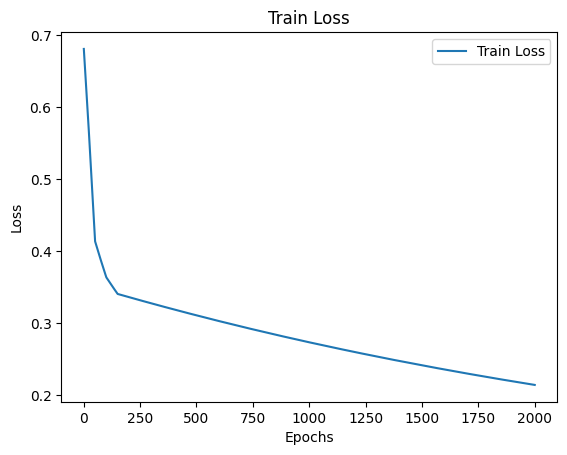

In [ ]:
# Plotando o gráfico comparativo
epochs = range(1, len(train_loss1) + 1)
plt.plot(epochs, train_loss1, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Loss')
plt.legend()
plt.show()

In [23]:
predictions_model1 = model1.predict(validation.values)

20/20 [==============================] - 0s 7ms/step


In [ ]:
predictions_model1

# Modelo 2 (otimizador Adadelta)

In [24]:
model2 = tf.keras.models.Sequential()

model2.add(tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)))

model2.add(tf.keras.layers.Dense(256, activation='linear'))

model2.add(tf.keras.layers.Dense(512, activation='relu'))

model2.add(tf.keras.layers.Dense(512, activation='linear'))

model2.add(tf.keras.layers.Dense(256, activation='relu'))

model2.add(tf.keras.layers.Dense(128, activation='linear'))

model2.add(tf.keras.layers.Dense(64, activation='relu'))

model2.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model2.compile(optimizer=tf.keras.optimizers.Adadelta(), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 128)               14464     
                                                                 
 dense_17 (Dense)            (None, 256)               33024     
                                                                 
 dense_18 (Dense)            (None, 512)               131584    
                                                                 
 dense_19 (Dense)            (None, 512)               262656    
                                                                 
 dense_20 (Dense)            (None, 256)               131328    
                                                                 
 dense_21 (Dense)            (None, 128)               32896     
                                                                 
 dense_22 (Dense)            (None, 64)               

In [26]:
history2 = model2.fit(
    X_train.values,
    np.array(y_train),
    epochs=200,
    batch_size=int(0.25*len(X)),
    verbose=1,
    callbacks=[early_stopping_callback,lr_scheduler_callback],
    validation_data=(X_test.values, np.array(y_test))
)

Epoch 1/200
3/3 [==============================] - 4s 440ms/step - loss: 0.6838 - accuracy: 0.6110 - val_loss: 0.6826 - val_accuracy: 0.6311 - lr: 0.0050
Epoch 2/200
3/3 [==============================] - 1s 190ms/step - loss: 0.6804 - accuracy: 0.6450 - val_loss: 0.6793 - val_accuracy: 0.6720 - lr: 0.0050
Epoch 3/200
3/3 [==============================] - 0s 156ms/step - loss: 0.6771 - accuracy: 0.6855 - val_loss: 0.6760 - val_accuracy: 0.7036 - lr: 0.0050
Epoch 4/200
3/3 [==============================] - 0s 162ms/step - loss: 0.6740 - accuracy: 0.7202 - val_loss: 0.6729 - val_accuracy: 0.7364 - lr: 0.0050
Epoch 5/200
3/3 [==============================] - 0s 158ms/step - loss: 0.6709 - accuracy: 0.7451 - val_loss: 0.6698 - val_accuracy: 0.7693 - lr: 0.0050
Epoch 6/200
3/3 [==============================] - 0s 166ms/step - loss: 0.6678 - accuracy: 0.7718 - val_loss: 0.6667 - val_accuracy: 0.7858 - lr: 0.0050
Epoch 7/200
3/3 [==============================] - 1s 240ms/step - loss: 0.6

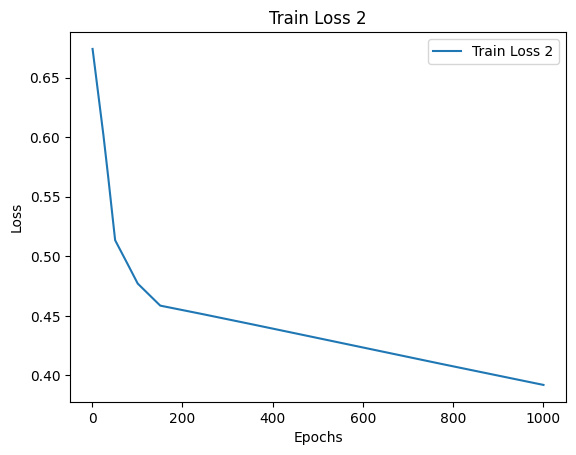

In [ ]:
train_loss2 = history2.history['loss']

# Plotando o gráfico comparativo
epochs = range(1, len(train_loss2) + 1)
plt.plot(epochs, train_loss2, label='Train Loss 2')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Loss 2')
plt.legend()
plt.show()

In [27]:
predictions_model2 = model2.predict(validation.values)

20/20 [==============================] - 0s 3ms/step


# Modelo 3 (otimizador Adagrad)

Epoch 1/1000
2/2 [==============================] - 2s 112ms/step - loss: 0.6764 - accuracy: 0.5261 - lr: 0.0050
Epoch 2/1000
2/2 [==============================] - 0s 102ms/step - loss: 0.6682 - accuracy: 0.5408 - lr: 0.0050
Epoch 3/1000
2/2 [==============================] - 0s 113ms/step - loss: 0.6599 - accuracy: 0.5621 - lr: 0.0050
Epoch 4/1000
2/2 [==============================] - 0s 114ms/step - loss: 0.6516 - accuracy: 0.5937 - lr: 0.0050
Epoch 5/1000
2/2 [==============================] - 0s 100ms/step - loss: 0.6433 - accuracy: 0.6484 - lr: 0.0050
Epoch 6/1000
2/2 [==============================] - 0s 106ms/step - loss: 0.6349 - accuracy: 0.7042 - lr: 0.0050
Epoch 7/1000
2/2 [==============================] - 0s 109ms/step - loss: 0.6264 - accuracy: 0.7528 - lr: 0.0050
Epoch 8/1000
2/2 [==============================] - 0s 101ms/step - loss: 0.6177 - accuracy: 0.7933 - lr: 0.0050
Epoch 9/1000
2/2 [==============================] - 0s 106ms/step - loss: 0.6087 - accuracy: 0.8

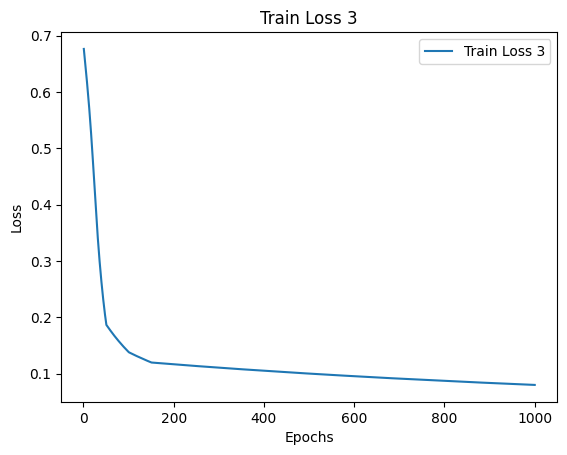

In [ ]:
model3 = tf.keras.models.Sequential()

model3.add(tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)))

model3.add(tf.keras.layers.Dense(256, activation='linear'))

model3.add(tf.keras.layers.Dense(512, activation='relu'))

model3.add(tf.keras.layers.Dense(512, activation='linear'))

model3.add(tf.keras.layers.Dense(256, activation='relu'))

model3.add(tf.keras.layers.Dense(128, activation='linear'))

model3.add(tf.keras.layers.Dense(64, activation='relu'))

model3.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model3.compile(optimizer=tf.keras.optimizers.Adagrad(), loss='binary_crossentropy', metrics=['accuracy'])

history3 = model3.fit(
    X_train.values,
    np.array(y_train),
    epochs=200,
    batch_size=int(0.25*len(X)),
    verbose=1,
    callbacks=[early_stopping_callback, lr_scheduler_callback],
    validation_data=(X_test.values, np.array(y_test))
)

train_loss3 = history3.history['loss']

# Plotando o gráfico comparativo
epochs = range(1, len(train_loss3) + 1)
plt.plot(epochs, train_loss3, label='Train Loss 3')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Loss 3')
plt.legend()
plt.show()

In [ ]:
predictions_model3 = model3.predict(validation.values)

20/20 [==============================] - 0s 4ms/step


# Modelo 4 (otimizador Nadam)

Epoch 1/200
3/3 [==============================] - 7s 879ms/step - loss: 1.2962 - accuracy: 0.6817 - val_loss: 5.7302 - val_accuracy: 0.4822 - lr: 0.0050
Epoch 2/200
3/3 [==============================] - 1s 307ms/step - loss: 2.2719 - accuracy: 0.7402 - val_loss: 0.3054 - val_accuracy: 0.9564 - lr: 0.0050
Epoch 3/200
3/3 [==============================] - 1s 321ms/step - loss: 0.2267 - accuracy: 0.9345 - val_loss: 0.0593 - val_accuracy: 0.9804 - lr: 0.0050
Epoch 4/200
3/3 [==============================] - 1s 156ms/step - loss: 0.0484 - accuracy: 0.9832 - val_loss: 0.3219 - val_accuracy: 0.8902 - lr: 0.0050
Epoch 5/200
3/3 [==============================] - 0s 167ms/step - loss: 0.3723 - accuracy: 0.9171 - val_loss: 0.0257 - val_accuracy: 0.9920 - lr: 0.0050
Epoch 6/200
3/3 [==============================] - 0s 159ms/step - loss: 0.0229 - accuracy: 0.9943 - val_loss: 0.0134 - val_accuracy: 0.9991 - lr: 0.0050
Epoch 7/200
3/3 [==============================] - 0s 168ms/step - loss: 0.0

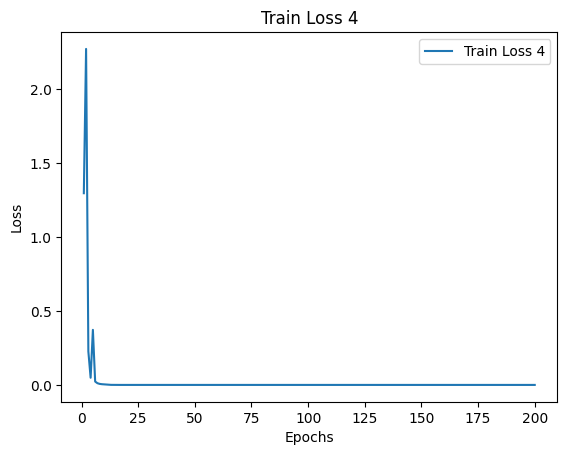

In [28]:
model4 = tf.keras.models.Sequential()

model4.add(tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)))

model4.add(tf.keras.layers.Dense(256, activation='linear'))

model4.add(tf.keras.layers.Dense(512, activation='relu'))

model4.add(tf.keras.layers.Dense(512, activation='linear'))

model4.add(tf.keras.layers.Dense(256, activation='relu'))

model4.add(tf.keras.layers.Dense(128, activation='linear'))

model4.add(tf.keras.layers.Dense(64, activation='relu'))

model4.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model4.compile(optimizer=tf.keras.optimizers.Nadam(), loss='binary_crossentropy', metrics=['accuracy'])

history4 = model4.fit(
    X_train.values,
    np.array(y_train),
    epochs=200,
    batch_size=int(0.25*len(X)),
    verbose=1,
    callbacks=[early_stopping_callback, lr_scheduler_callback],
    validation_data=(X_test.values, np.array(y_test))
)

train_loss4 = history4.history['loss']

# Plotando o gráfico comparativo
epochs = range(1, len(train_loss4) + 1)
plt.plot(epochs, train_loss4, label='Train Loss 4')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Loss 4')
plt.legend()
plt.show()

In [33]:
predictions_model4 = model4.predict(validation.values)

20/20 [==============================] - 0s 3ms/step


# Modelo 5 (otimizador Lion)

Epoch 1/1000
2/2 [==============================] - 1s 108ms/step - loss: 0.6309 - accuracy: 0.6000 - lr: 0.0050
Epoch 2/1000
2/2 [==============================] - 0s 96ms/step - loss: 9.6765 - accuracy: 0.5065 - lr: 0.0050
Epoch 3/1000
2/2 [==============================] - 0s 98ms/step - loss: 0.6176 - accuracy: 0.6150 - lr: 0.0050
Epoch 4/1000
2/2 [==============================] - 0s 105ms/step - loss: 6.3449 - accuracy: 0.7842 - lr: 0.0050
Epoch 5/1000
2/2 [==============================] - 0s 97ms/step - loss: 1.0185 - accuracy: 0.6442 - lr: 0.0050
Epoch 6/1000
2/2 [==============================] - 0s 98ms/step - loss: 0.1571 - accuracy: 0.9381 - lr: 0.0050
Epoch 7/1000
2/2 [==============================] - 0s 100ms/step - loss: 0.3962 - accuracy: 0.8310 - lr: 0.0050
Epoch 8/1000
2/2 [==============================] - 0s 105ms/step - loss: 0.6053 - accuracy: 0.9109 - lr: 0.0050
Epoch 9/1000
2/2 [==============================] - 0s 96ms/step - loss: 0.3145 - accuracy: 0.8869 -

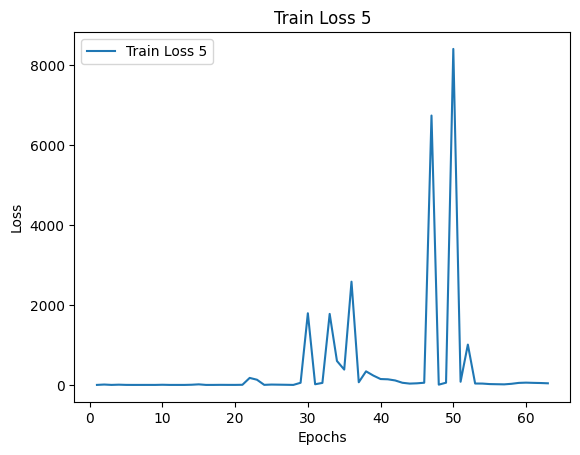

In [ ]:
model5 = tf.keras.models.Sequential()

model5.add(tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)))

model5.add(tf.keras.layers.Dense(256, activation='linear'))

model5.add(tf.keras.layers.Dense(512, activation='relu'))

model5.add(tf.keras.layers.Dense(512, activation='linear'))

model5.add(tf.keras.layers.Dense(256, activation='relu'))

model5.add(tf.keras.layers.Dense(128, activation='linear'))

model5.add(tf.keras.layers.Dense(64, activation='relu'))

model5.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model5.compile(optimizer=tf.keras.optimizers.Lion(), loss='binary_crossentropy', metrics=['accuracy'])

history5 = model5.fit(
    X_train.values,
    np.array(y_train),
    epochs=1000,
    batch_size=int(0.50*len(X)),
    verbose=1,
    callbacks=[early_stopping_callback, lr_scheduler_callback]
)

train_loss5 = history5.history['loss']

# Plotando o gráfico comparativo
epochs = range(1, len(train_loss5) + 1)
plt.plot(epochs, train_loss5, label='Train Loss 5')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Loss 5')
plt.legend()
plt.show()

In [ ]:
predictions_model5 = model5.predict(validation.values)

20/20 [==============================] - 0s 4ms/step


# Modelo 6 (otimizador Adamax)

Epoch 1/1000
2/2 [==============================] - 2s 106ms/step - loss: 0.7726 - accuracy: 0.4893 - lr: 0.0050
Epoch 2/1000
2/2 [==============================] - 0s 101ms/step - loss: 1.4476 - accuracy: 0.4821 - lr: 0.0050
Epoch 3/1000
2/2 [==============================] - 0s 98ms/step - loss: 0.4311 - accuracy: 0.8987 - lr: 0.0050
Epoch 4/1000
2/2 [==============================] - 0s 105ms/step - loss: 0.1888 - accuracy: 0.9232 - lr: 0.0050
Epoch 5/1000
2/2 [==============================] - 0s 100ms/step - loss: 0.0665 - accuracy: 0.9754 - lr: 0.0050
Epoch 6/1000
2/2 [==============================] - 0s 102ms/step - loss: 0.0258 - accuracy: 0.9910 - lr: 0.0050
Epoch 7/1000
2/2 [==============================] - 0s 110ms/step - loss: 0.0096 - accuracy: 0.9964 - lr: 0.0050
Epoch 8/1000
2/2 [==============================] - 0s 102ms/step - loss: 0.0036 - accuracy: 0.9983 - lr: 0.0050
Epoch 9/1000
2/2 [==============================] - 0s 101ms/step - loss: 0.0015 - accuracy: 0.99

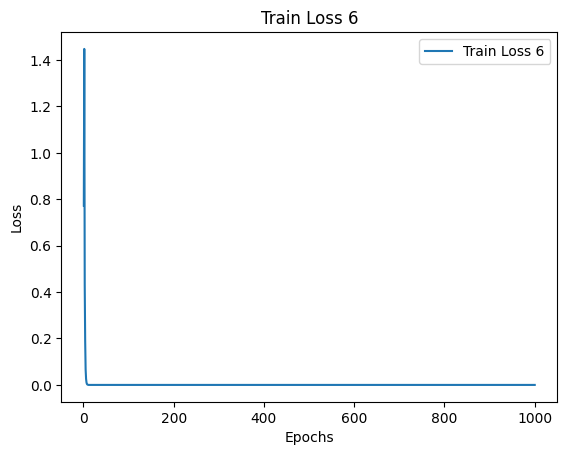

In [ ]:
model6 = tf.keras.models.Sequential()

model6.add(tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)))

model6.add(tf.keras.layers.Dense(256, activation='linear'))

model6.add(tf.keras.layers.Dense(512, activation='relu'))

model6.add(tf.keras.layers.Dense(512, activation='linear'))

model6.add(tf.keras.layers.Dense(256, activation='relu'))

model6.add(tf.keras.layers.Dense(128, activation='linear'))

model6.add(tf.keras.layers.Dense(64, activation='relu'))

model6.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model6.compile(optimizer=tf.keras.optimizers.Adamax(), loss='binary_crossentropy', metrics=['accuracy'])

history6 = model6.fit(
    X_train.values,
    np.array(y_train),
    epochs=1000,
    batch_size=int(0.50*len(X)),
    verbose=1,
    callbacks=[early_stopping_callback, lr_scheduler_callback]
)

train_loss6 = history6.history['loss']

# Plotando o gráfico comparativo
epochs = range(1, len(train_loss6) + 1)
plt.plot(epochs, train_loss6, label='Train Loss 6')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Loss 6')
plt.legend()
plt.show()

In [ ]:
predictions_model6 = model6.predict(validation.values)

20/20 [==============================] - 0s 2ms/step


## Inserindo os dados no CSV

In [37]:
transforma_bin = lambda x: 1 if x > 0.5 else 0

result = pd.DataFrame()

result['index'] = index_values

In [38]:
y_pred = [transforma_bin(float(x)) for x in predictions_model1.flatten()]

y_pred = pd.Series(y_pred)

y_pred = y_pred.map({0:'e',1:'p'})

result['CLASS_MODELO_1'] = y_pred

In [39]:
y_pred = [transforma_bin(float(x)) for x in predictions_model2.flatten()]

y_pred = pd.Series(y_pred)

y_pred = y_pred.map({0:'e',1:'p'})

result['CLASS_MODELO_2'] = y_pred

In [40]:
y_pred = [transforma_bin(float(x)) for x in predictions_model4.flatten()]

y_pred = pd.Series(y_pred)

y_pred = y_pred.map({0:'e',1:'p'})

result['CLASS_MODELO_4'] = y_pred

In [41]:
result

,index,CLASS_MODELO_1,CLASS_MODELO_2,CLASS_MODELO_4
0,5023,e,p,e
1,741,e,e,e
2,6797,p,p,p
3,2088,e,e,e
4,4771,e,p,p
...,...,...,...,...
619,4123,p,p,p
620,6993,p,p,p
621,246,e,e,e
622,7935,p,p,p


In [42]:
result_export = result[['index', 'CLASS_MODELO_1', 'CLASS_MODELO_2', 'CLASS_MODELO_4']]

result_export.to_csv('/content/drive/MyDrive/Colab Notebooks/Data Science/AC3/DAVID_ALMEIDA_MATHEUS_OLIVEIRA.csv')

In [ ]:
csv_values

,index,CLASS_MODELO_1,CLASS_MODELO_2,CLASS_MODELO_3,CLASS_MODELO_4,CLASS_MODELO_5,CLASS_MODELO_6
0,5023,e,e,e,p,e,p
1,741,p,p,p,p,e,p
2,6797,e,e,e,e,e,e
3,2088,p,p,p,p,e,p
4,4771,e,e,e,e,e,e
...,...,...,...,...,...,...,...
619,4123,e,e,e,e,e,e
620,6993,e,e,e,e,e,e
621,246,p,p,e,p,e,p
622,7935,e,e,e,e,e,e


In [ ]:
csv_values.to_csv('/content/drive/MyDrive/Colab Notebooks/Data Science/AC3/DAVID_ALMEIDA_MATHEUS_OLIVEIRA.csv', index=False)